<h1><center>Part 1:Creating a panoramic shot from pictures using OpenCV</center></h1>

In this project we will create panoramic shots from a set of images. The source of the images is listed [here](https://github.com/ppwwyyxx/OpenPano/releases/tag/0.1).<br>
The first thing we need to do is to import the required libraries.

In [1]:
from cv2 import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

Then we need to read the images from the directory. For this purpose, we will create a function that will read and return all images from a single directory.

In [2]:
def read_dir(directory_path):
    files = os.listdir(directory_path)
    image_paths = [os.path.join(directory_path, file) for file in files if file.endswith((".jpg", ".JPG"))]
    images = [cv.imread(path) for path in image_paths]
    return images

The next step is to create a function that extracts the keypoints and the descriptors from a given image. For this purpose we will use the SIFT library to our advantage. We then need a function that will 

In [3]:
sift = cv.SIFT_create(3200)
matcher = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

def get_k_and_d(image):
    key = sift.detect(image)
    desc = sift.compute(image, key)
    return key, desc[1]

def match_images(image_desc1, image_desc2, keep_best_ratio=0.0):
    matches = matcher.match(image_desc1, image_desc2)
    matches = sorted(matches, key=lambda x: x.distance)
    matches = matches[:int((1 - keep_best_ratio) * len(matches))]
    return matches

We also chose do add the option to reject the least accurate matchings, improving the stiching performance. Later we will see that if we have a large number of images we will reduce their resolution to make the process of extracting the important descriptors faster. Finally, we will also convert the images to grayscale in order to remove 2 of the 3 channels of the image.

In [4]:
def crop_image(image, threshold=5):
    if len(image.shape) == 3:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray = image
    mask = gray > threshold
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]
    y1, y2 = rows[0], rows[-1] + 1
    x1, x2 = cols[0], cols[-1] + 1
    return image[y1:y2, x1:x2]
    
def stitch_images(image1, image2, keep_best_ratio=0.0):
    kp1, desc1 = get_k_and_d(cv.cvtColor(image1, cv.COLOR_BGR2GRAY))
    kp2, desc2 = get_k_and_d(cv.cvtColor(image2, cv.COLOR_BGR2GRAY))
    matches = match_images(desc1, desc2, keep_best_ratio-keep_best_ratio)
    
    src_pt = []
    dst_pt = []
    for match in matches:
        src_pt.append(kp1[match.queryIdx].pt)
        dst_pt.append(kp2[match.trainIdx].pt)
    src_pt = np.array(src_pt).reshape(-1, 1, 2)
    dst_pt = np.array(dst_pt).reshape(-1, 1, 2)

    homography, _ = cv.findHomography(dst_pt, src_pt, cv.RANSAC, 5.0)
    result = cv.warpPerspective(image2, homography, (image1.shape[1] * 2, image1.shape[0]))
    #mask = np.ones_like(image2, dtype=np.uint8) * 255
    #center = (image2.shape[1] // 2, image2.shape[0] // 2)
    result[0:image1.shape[0], 0:image1.shape[1]] = image1
    #result = cv.seamlessClone(image2, result, mask, center, cv.NORMAL_CLONE)
    result = crop_image(result)
    return result

As we can see we also added a crop function that removes unfilled space inside our image. Then, the process of stiching the images is quite simple: We get the keypoints and the desriptors from both our images, we match them, we get the points we want, we find the homography and then we perform a transform in order to create the final result. We then crop the unwanted blank area that is created by the operation. Lets run a test and see if the result is the expected one.

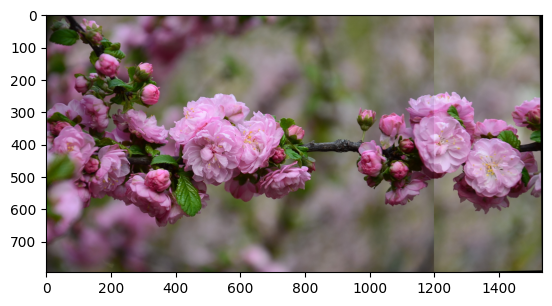

In [5]:
test_dir = 'res/flower'
test_images = read_dir(test_dir)
test1 = stitch_images(test_images[0], test_images[1])
plt.imshow(cv.cvtColor(test1, cv.COLOR_BGR2RGB))
plt.show()

The result is the expected one. All that remains is to create a function that will perform this operation as many times as it is needed. Logically, this operation can be broken down to the following logic:<br>
- We start with stitching the 2 leftmost images.
We perform N_images - 2 times:<br>
- stitch the previous result image with the leftmost image that is still not been used.

In [6]:
def create_panorama_from_dir(directory, keep_best_ratio=0.0):
    images = read_dir(directory)
    while(len(images)>1):
        new_images = []
        for i in range(0, len(images) - 1, 4):
            new_images.append(stitch_images(images[i], images[i+1], keep_best_ratio=keep_best_ratio))
        #images = new_images
        if(len(images)>3):
            for i in range(2, len(images) - 1, 4):
                new_images.append(stitch_images(images[i+1], images[i], keep_best_ratio=keep_best_ratio))
        images = new_images
    return images[0]

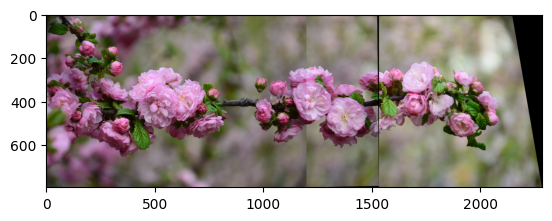

In [7]:
flower_panorama = create_panorama_from_dir('res/flower')
plt.imshow(cv.cvtColor(flower_panorama, cv.COLOR_BGR2RGB))

The result is a success! Although not perfect, we created a very good panoramic shot!

In [8]:
CMU0_panorama = create_panorama_from_dir('res/CMU0')
CMU1_panorama = create_panorama_from_dir('res/CMU1')
CMU2_panorama = create_panorama_from_dir('res/CMU2')
myself_panorama = create_panorama_from_dir('res/myself')
NSH_panorama = create_panorama_from_dir('res/NSH')
uav_panorama = create_panorama_from_dir('res/uav')
zijing_panorama = create_panorama_from_dir('res/zijing')

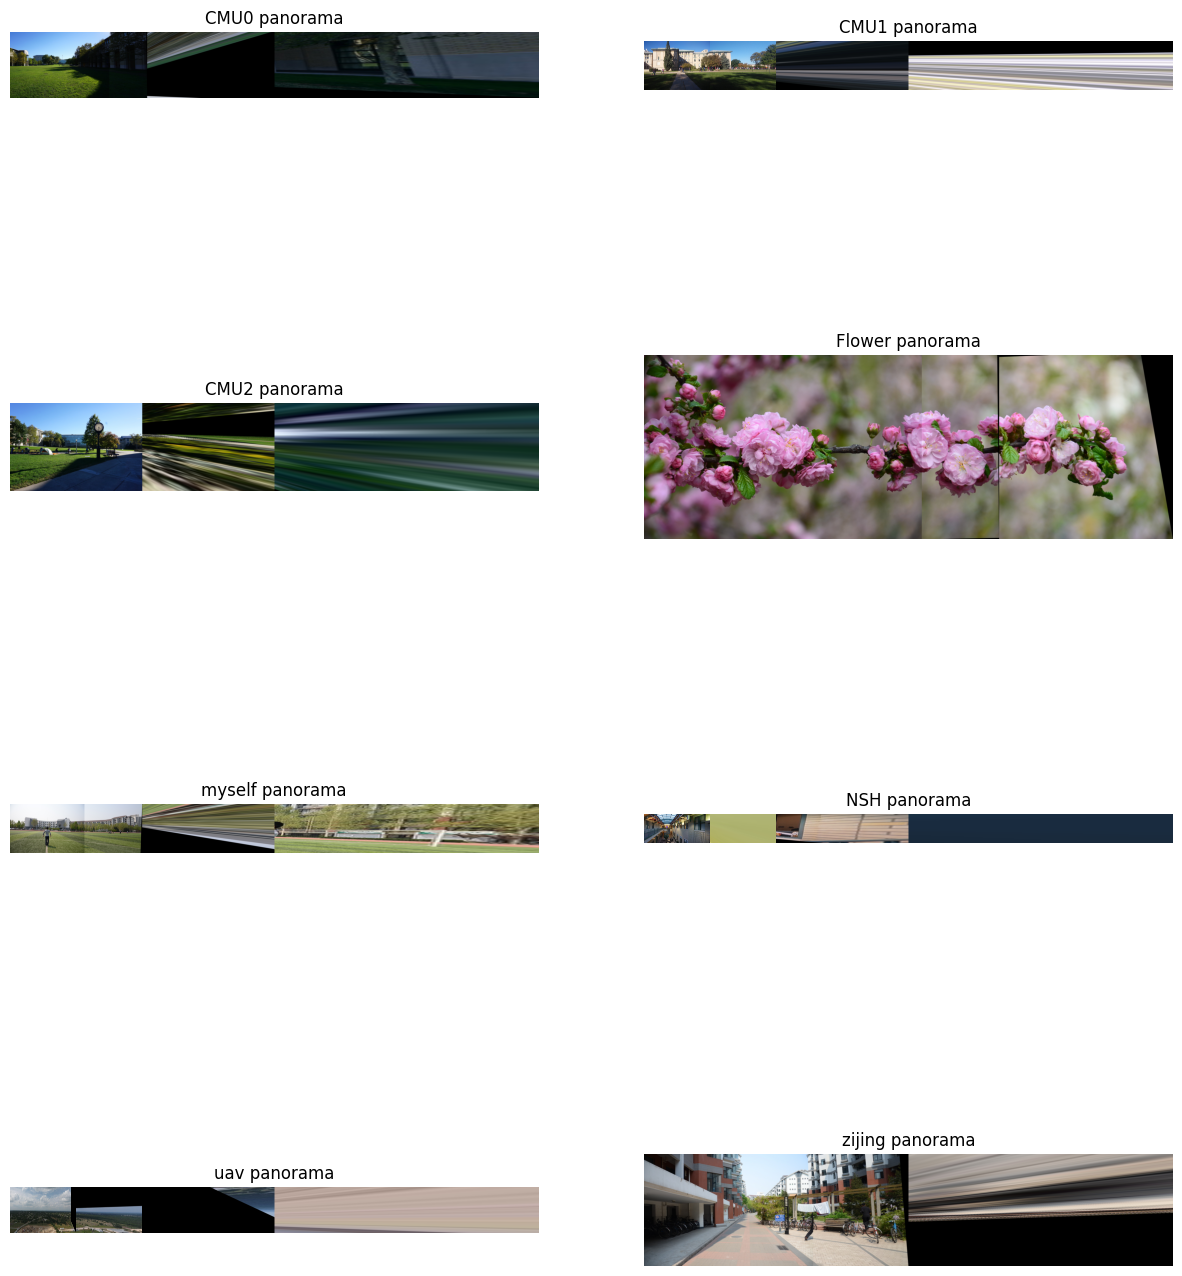

In [9]:
fix, ax = plt.subplots(4, 2, figsize=(15,19))
ax[0, 0].imshow(cv.cvtColor(CMU0_panorama, cv.COLOR_BGR2RGB))
ax[0, 1].imshow(cv.cvtColor(CMU1_panorama, cv.COLOR_BGR2RGB))
ax[1, 0].imshow(cv.cvtColor(CMU2_panorama, cv.COLOR_BGR2RGB))
ax[1, 1].imshow(cv.cvtColor(flower_panorama, cv.COLOR_BGR2RGB))
ax[2, 0].imshow(cv.cvtColor(myself_panorama, cv.COLOR_BGR2RGB))
ax[2, 1].imshow(cv.cvtColor(NSH_panorama, cv.COLOR_BGR2RGB))
ax[3, 0].imshow(cv.cvtColor(uav_panorama, cv.COLOR_BGR2RGB))
ax[3, 1].imshow(cv.cvtColor(zijing_panorama, cv.COLOR_BGR2RGB))
ax[0, 0].set_title('CMU0 panorama')
ax[0, 1].set_title('CMU1 panorama')
ax[1, 0].set_title('CMU2 panorama')
ax[1, 1].set_title('Flower panorama')
ax[2, 0].set_title('myself panorama')
ax[2, 1].set_title('NSH panorama')
ax[3, 0].set_title('uav panorama')
ax[3, 1].set_title('zijing panorama')
for i in range(8):
    ax[i // 2, i % 2].axis('off')
plt.show()

In the end, we need to note that it took a lot of time to run all the panoramic shots, which is not a suprise: Some folders may have up to 18 images, that also extend in the vertical directions, which also explains the inaccuracy of some panoramic shots. The simple solution is to downscale all the images from the directory and then use the best matches, improving our time.<br>
It is clear that if we have multiple images that extend both horizontally and vertically, the algorithm shown above will not work. The opencv library has a bulit in stitching method. How well does that respond to not completely organized images?

In [10]:
stitcher = cv.createStitcher()
CMU0_images = read_dir('res/CMU0')
CMU1_images = read_dir('res/CMU1')
CMU2_images = read_dir('res/CMU2')
flower_images = read_dir('res/flower')
myself_images = read_dir('res/myself')
NSH_images = read_dir('res/NSH')
uav_images = read_dir('res/uav')
zijing_images = read_dir('res/zijing')
status, CMU0_panorama_s = stitcher.stitch(CMU0_images)

In [11]:
status, CMU1_panorama_s = stitcher.stitch(CMU1_images)

In [12]:
status, CMU2_panorama_s = stitcher.stitch(CMU2_images)

In [13]:
status, flower_panorama_s = stitcher.stitch(flower_images)

In [14]:
status, myself_panorama_s = stitcher.stitch(myself_images)

In [15]:
status, NSH_panorama_s = stitcher.stitch(NSH_images)

In [16]:
#status, uav_panorama_s = stitcher.stitch(uav_images)

In [17]:
status, zijing_panorama_s = stitcher.stitch(zijing_images)

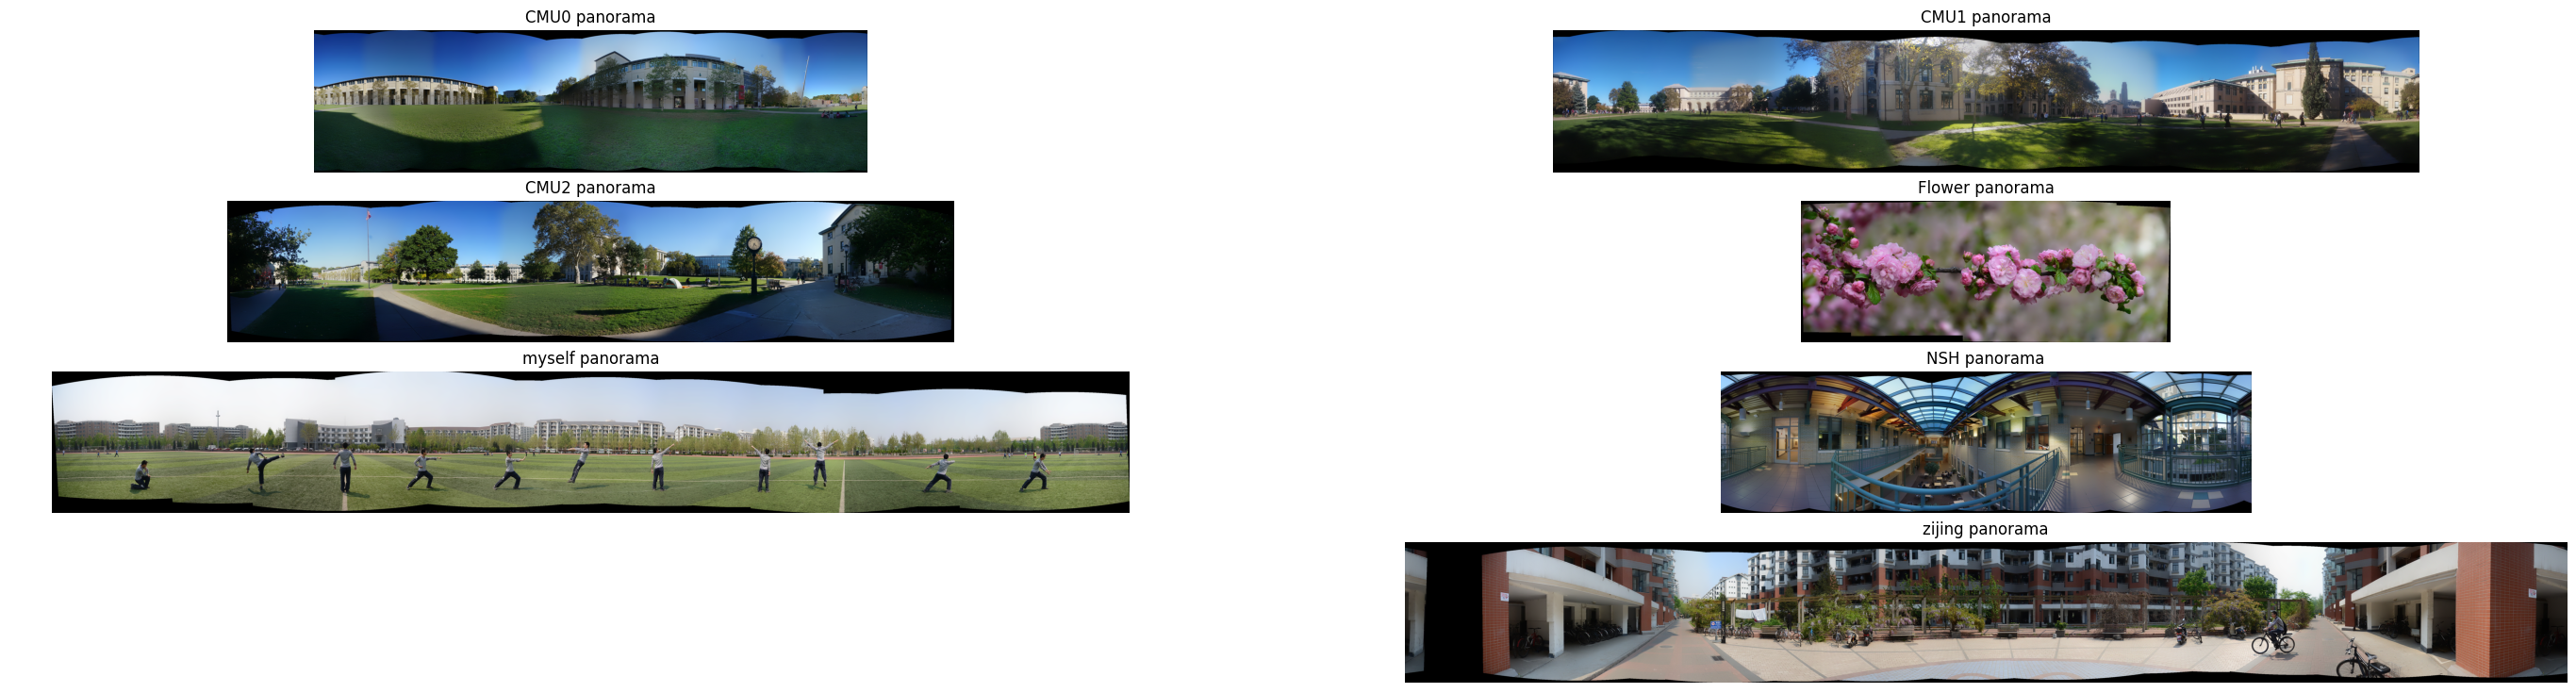

In [20]:
fix, ax = plt.subplots(4, 2, figsize=(35,9))
ax[0, 0].imshow(cv.cvtColor(CMU0_panorama_s, cv.COLOR_BGR2RGB))
ax[0, 1].imshow(cv.cvtColor(CMU1_panorama_s, cv.COLOR_BGR2RGB))
ax[1, 0].imshow(cv.cvtColor(CMU2_panorama_s, cv.COLOR_BGR2RGB))
ax[1, 1].imshow(cv.cvtColor(flower_panorama_s, cv.COLOR_BGR2RGB))
ax[2, 0].imshow(cv.cvtColor(myself_panorama_s, cv.COLOR_BGR2RGB))
ax[2, 1].imshow(cv.cvtColor(NSH_panorama_s, cv.COLOR_BGR2RGB))
#ax[3, 0].imshow(cv.cvtColor(uav_panorama_s, cv.COLOR_BGR2RGB))
ax[3, 1].imshow(cv.cvtColor(zijing_panorama_s, cv.COLOR_BGR2RGB))
ax[0, 0].set_title('CMU0 panorama')
ax[0, 1].set_title('CMU1 panorama')
ax[1, 0].set_title('CMU2 panorama')
ax[1, 1].set_title('Flower panorama')
ax[2, 0].set_title('myself panorama')
ax[2, 1].set_title('NSH panorama')
#ax[3, 0].set_title('uav panorama')
ax[3, 1].set_title('zijing panorama')
for i in range(8):
    ax[i // 2, i % 2].axis('off')
plt.show()

As expected, the results are much more impressive! If we want even better panoramic shots, we will need to move to convolutional neural networks. One major disadvantage the high level stitcher has it consumes much more time than our algorithm.

<h2>Part 2: Panoramic shot creation using convolutional networks</h2>